# LSTM - Market Predictions
Example of preparing data for an LSTM RNN

In [9]:
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt


# finnhub API ----------------------------------------------
import finnhub
configuration = finnhub.Configuration(
    api_key={
        'token': 'brk2mhvrh5r9g3othsag'
    }
)
finnhub_client = finnhub.DefaultApi(finnhub.ApiClient(configuration))

#-----------------------------------------------------------

# Select a symbol to work with 
symbol = 'GLD' # Gold ETF

## Get Raw Data
- Candlestick data for the ticker symbol
- Add technical indicator data for additional features

In [25]:
# technical indicators
start = int(datetime(2014, 7, 1).timestamp())
end = int(datetime.today().timestamp())
technames = pd.read_csv('datamine/tilabels.csv')
ti_name = [n[0].lower() for n in technames.values]
ti_label = [n[1].split(',') for n in technames.values]

ti_df = pd.DataFrame()
for i in range(len(ti_name)):
    ti = finnhub_client.technical_indicator(symbol=symbol,
                                             resolution='D',
                                             _from=start,
                                             to=end,
                                             indicator=ti_name[i])

    ti_data = pd.DataFrame(ti)
    candlestick_labels = ['c','h','l','o','t','v', 's']
    ti_data.columns = [col.replace("\'","") for col in ti_data.columns]
    if i==0:
        ti_df = pd.concat([ti_df, ti_data], axis=1) # Append all candlesticks
        ti_df.columns = [f'{ti_name[i]}_{col}' if col not in candlestick_labels else col for col in ti_data.columns if col]
    else:
        ti_metrics = ti_data[ti_label[i]]
        ti_metrics.columns = [f'{ti_name[i]}_{col}' for col in ti_metrics.columns]
        ti_df = pd.concat([ti_df, ti_metrics], axis=1) # only append TI name

# convert timestamp to date
ti_df['t'] = ti_df.t.apply(date.fromtimestamp)


# rename columns for convenience
col_dict = {
'o':'open',
'h':'high',
'l':'low',
'c':'close',
'v':'volume',
't':'time'
}

ti_df.rename(columns=col_dict, inplace=True)



#### A view of the raw data:

To make things easier to follow, I limited the data to a few select columns

In [42]:
features = ['time','close','volume','rsi_rsi','willr_willr']
df = ti_df[ti_df.time >= date(2017,1,1)][features].copy()
df.head()

,time,close,volume,rsi_rsi,willr_willr
632,2017-01-02,110.47,7527400,76.688317,-28.804348
633,2017-01-03,110.86,4904100,81.369163,-19.459459
634,2017-01-04,112.58,9606800,91.998195,-10.084034
635,2017-01-05,111.75,7686100,65.110512,-51.072961
636,2017-01-08,112.67,5674600,76.520124,-25.170068


In [143]:
df.to_csv('GLD_data.csv')

## Analysis Setup
- What outcome to predict?
- split training and test data
- creating the input and output arrays

#### Outcome
At first glance, future closing price would be an obvious outcome to predict. 

The problem with using future closing price is an LSTM will lean too heavily on price from the previous period, and all you end up with is a prediction that is a lag of the previous price.

I'll use both a continuous outcome and binary outcome as examples, using a 10-day %change

I adjusted my outcome to be a binary indicator of whether or not there is a postive or negative trend (based on rate of change in 10 periods)

In [44]:
df['gain10'] = df.close.pct_change(10)
df['trend10'] = np.where(df.gain10 > 0, 1, 0)
df.iloc[10:].head()

,time,close,volume,rsi_rsi,willr_willr,gain10,trend10
646,2017-01-23,115.27,5798800,55.665774,-48.648649,0.023076,1
647,2017-01-24,114.32,6697500,30.300179,-74.297189,0.010340,1
648,2017-01-25,113.26,5390500,17.190041,-86.520376,-0.002115,0
649,2017-01-26,113.49,6706600,27.412124,-58.282209,-0.003687,0
650,2017-01-29,113.97,7687800,47.643723,-22.147651,-0.002101,0


#### Split training and test data
I'll set test data to be the year 2020

In [47]:
# Split Training and Test Data
test_cutoff = date(2020,1,1) # uses 2020 as test data
test_df = df[df.time >= test_cutoff]
train_df = df[df.time < test_cutoff]
print('train df size:', train_df.shape[0])
print('test df size:', test_df.shape[0])

train df size: 754
test df size: 151


In [116]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
predictors = ['close','volume','rsi_rsi','willr_willr']
outcome = ['gain10']
scaler = MinMaxScaler() # scale 0 to 1
train = train_df[predictors + outcome].to_numpy().reshape(-1,len(predictors) + 1)
train = scaler.fit_transform(train)
train.shape

(754, 5)

#### Creating the Input and Output Data
- This is where I frame my analysis. I want to use historical data to predict a 10-period trend <i>in the future</i>
- Therefore, I'll decide to use 50 periods of historical data to predict a trend 10 periods into the future. I want to know if an investment will be positive after 10 trading periods.
- The input is a 3-dimensional array and the output is a 1-dimensional array

In [117]:
# example: 50 periods used to predict price on 50th period
hist_days = 50 # periods of historical data used to predict future price
future_days = 10 # periods into future prediction is made

future_idx = hist_days + future_days # save index for predicted price
output_data = train[future_idx:, -1] # create outcome array
input_data = np.array([train[i:i+hist_days, :-1] for i in range(len(output_data))]) # input data is chunked into blocks of size hist_days

print("Input shape:",input_data.shape)
print("Output shape:",output_data.shape)

Input shape: (690, 50, 4)
Output shape: (690,)


Example of the data setup. Each sequence of 50 time points is used to predict an outcome 10 periods after the last period in the batch. The numbers used in this image are randomly generated.

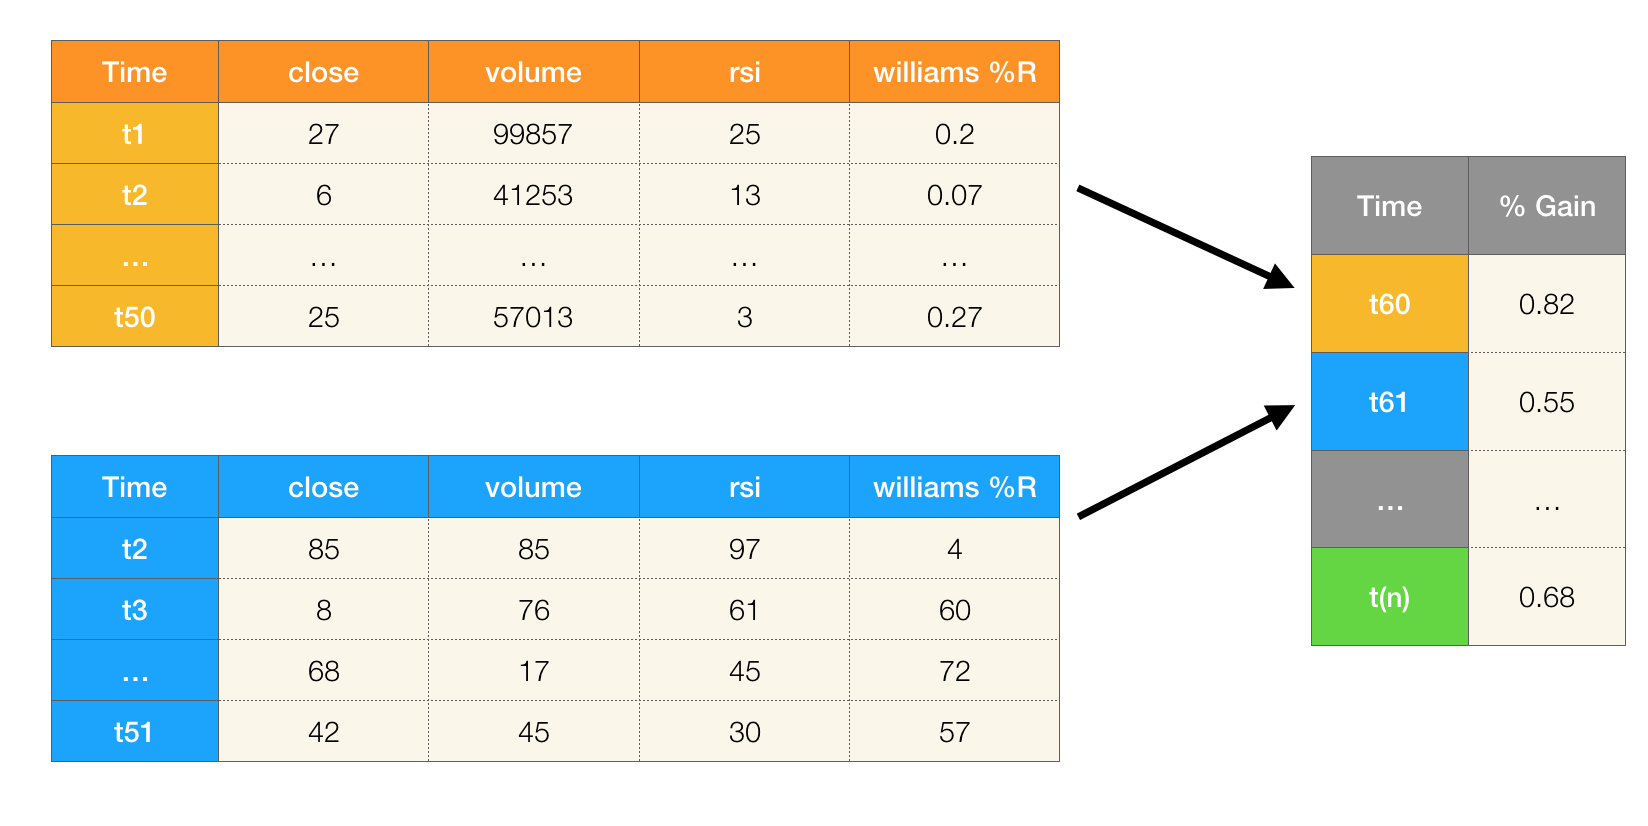

## LSTM - continuous outcome
- An example with a continuous outcome (% gain over 10 periods)
- The performance of this will be poor, but I'm just including it as an example

### Define the LSTM (using keras)
This is where I define the architecture of the LSTM

In [118]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# initialize with a sequential model
model = Sequential()

# add 1st layer with dropout
model.add(
          LSTM(units=50,
               return_sequences=True,
               input_shape = (input_data.shape[1], input_data.shape[2])
               )
           ) # need to return sequences when stacking LSTM layers
model.add(Dropout(0.2))

# add 2nd layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# add 3rd layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# add 4th layer
model.add(LSTM(units=100)) # do not need to return sequences because the next layer is not LSTM
model.add(Dropout(0.2))

# add a Dense layer
model.add(Dense(units=1)) # units=1 for prediction of a single value

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Define callbacks
es = EarlyStopping(monitor='loss', mode='min', verbose=1)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50, 50)            11000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)              

### Fit the model

In [119]:
# fit the model
history = model.fit(input_data, output_data, epochs=20, batch_size=hist_days, callbacks=[es])

Epoch 1/20
690/690 [==============================] - 3s 5ms/step - loss: 0.0552 - mse: 0.0552
Epoch 2/20
690/690 [==============================] - 2s 3ms/step - loss: 0.0342 - mse: 0.0342
Epoch 3/20
690/690 [==============================] - 2s 3ms/step - loss: 0.0348 - mse: 0.0348
Epoch 00003: early stopping


### Predict Test Data

In [120]:
# apply scaling factor to test data
scaler = MinMaxScaler()
test = test_df.reset_index()[predictors + outcome].to_numpy()
test = scaler.fit_transform(test)

# test data
test_output_data = test[future_idx:, -1]
test_input_data = np.array([test[i:i+hist_days, :-1] for i in range(len(test)-hist_days-future_days)])
# input_data = np.array([train[i:i+hist_days, :-1] for i in range(len(output_data))]) # input data is chunked into blocks of size hist_days

print("Input shape:",test_input_data.shape)
print("Output shape:",test_output_data.shape)

Input shape: (87, 50, 4)
Output shape: (87,)


In [121]:
# Generate Predictions
predictions = model.predict(test_input_data)
print(predictions.shape)

from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(test_output_data, predictions)
print('Test MSE:', test_mse)

(87, 1)
Test MSE: 0.09354822374453091


In [122]:
# convert back to original scale
preds_all_cols = np.concatenate((np.zeros((len(predictions),len(predictors))), predictions), axis=1)
predictions_unscale = scaler.inverse_transform(preds_all_cols)[:,-1]


In [125]:
predictions_unscale[:10]

array([-0.02930512, -0.02966172, -0.03021336, -0.0309282 , -0.03179984,
       -0.03279133, -0.03378752, -0.03466961, -0.03536088, -0.03583907])

In [126]:
test_df.iloc[future_idx:]['gain10']

1450    0.089501
1451    0.072317
1452    0.017210
1453    0.022141
1454    0.035565
          ...   
1532    0.089995
1533    0.085995
1534    0.095896
1535    0.089506
1536    0.093464
Name: gain10, Length: 87, dtype: float64

## Plot Results 

In [127]:
skip_ahead = test_df.first_valid_index() - (hist_days+future_days)
predicted_price = pd.DataFrame(predictions_unscale,
                               index=range(test_df.first_valid_index() + hist_days + future_days, test_df.last_valid_index() + 1),
                               columns=['gain10'])

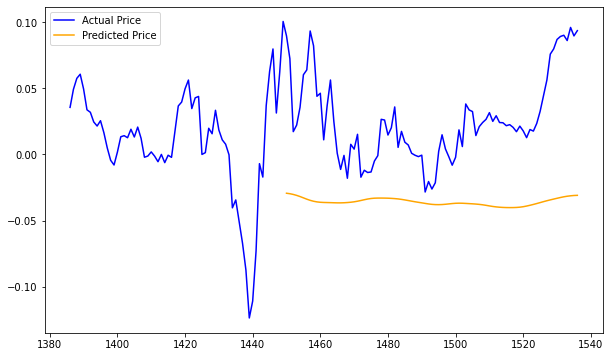

In [128]:
plt.figure(figsize=(10,6))
plt.plot(test_df.gain10, color='blue', label='Actual Price')
plt.plot(predicted_price.gain10, color='orange', label='Predicted Price')
plt.legend()

## LSTM Binary Model

In [129]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
predictors = ['close','volume','rsi_rsi','willr_willr']
outcome = ['trend10']
scaler = MinMaxScaler() # scale 0 to 1
train = train_df[predictors].to_numpy().reshape(-1,len(predictors))
train = scaler.fit_transform(train)
train.shape

# example: 50 periods used to predict price on 50th period
hist_days = 50 # periods of historical data used to predict future price
future_days = 10 # periods into future prediction is made

future_idx = hist_days + future_days # save index for predicted price
output_data = train_df.trend10[future_idx:] # create outcome array
input_data = np.array([train[i:i+hist_days] for i in range(len(output_data))]) # input data is chunked into blocks of size hist_days

print("Input shape:",input_data.shape)
print("Output shape:",output_data.shape)

Input shape: (690, 50, 4)
Output shape: (690,)


In [130]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# initialize with a sequential model
model = Sequential()

# add 1st layer with dropout
model.add(
          LSTM(units=50,
               return_sequences=True,
               input_shape = (input_data.shape[1], input_data.shape[2])
               )
           ) # need to return sequences when stacking LSTM layers
model.add(Dropout(0.2))

# add 2nd layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# add 3rd layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# add 4th layer
model.add(LSTM(units=100)) # do not need to return sequences because the next layer is not LSTM
model.add(Dropout(0.2))

# add a Dense layer
model.add(Dense(1, activation='sigmoid')) # units=1 for prediction of a single value

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
es = EarlyStopping(monitor='loss', mode='min', verbose=1)

model.summary()

W0806 12:15:40.090640 4713600448 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 50, 50)            11000     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)              

In [131]:
# fit the model
history = model.fit(input_data, output_data, epochs=20, batch_size=hist_days, callbacks=[es])

Epoch 1/20
690/690 [==============================] - 3s 5ms/step - loss: 0.6918 - accuracy: 0.5290
Epoch 2/20
690/690 [==============================] - 2s 3ms/step - loss: 0.6875 - accuracy: 0.5319
Epoch 3/20
690/690 [==============================] - 2s 2ms/step - loss: 0.6863 - accuracy: 0.5797
Epoch 4/20
690/690 [==============================] - 2s 3ms/step - loss: 0.6830 - accuracy: 0.5551
Epoch 5/20
690/690 [==============================] - 2s 3ms/step - loss: 0.6824 - accuracy: 0.5435
Epoch 6/20
690/690 [==============================] - 2s 3ms/step - loss: 0.6750 - accuracy: 0.5609
Epoch 7/20
690/690 [==============================] - 2s 3ms/step - loss: 0.6757 - accuracy: 0.5725
Epoch 00007: early stopping


In [132]:
# apply scaling factor to test data
scaler = MinMaxScaler()
test = test_df.reset_index()[predictors].to_numpy()
test = scaler.fit_transform(test)

# test data
test_output_data = test_df.trend10[future_idx:]
test_input_data = np.array([test[i:i+hist_days] for i in range(len(test)-hist_days-future_days)])

print("Input shape:",test_input_data.shape)
print("Output shape:",test_output_data.shape)

Input shape: (87, 50, 4)
Output shape: (87,)


In [133]:
# Generate Predictions
predictions = model.predict(test_input_data)
print(predictions.shape)

(87, 1)


In [139]:
# Arbitrarily set cutoff at 0.5
pred_class = np.where(predictions > 0.5, 1, 0)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, 
precision_recall_fscore_support, classification_report

In [141]:
print(classification_report(test_output_data, pred_class))

              precision    recall  f1-score   support

           0       0.03      0.05      0.04        19
           1       0.64      0.47      0.54        68

    accuracy                           0.38        87
   macro avg       0.33      0.26      0.29        87
weighted avg       0.51      0.38      0.43        87



Well...precision is at 64%. Not terrible if you think like Jon Simons, where you only have to be right >50% of the time.

---

# Theoretical Setup for Predicting Future cost of Members

- The idea would be that each batch of 24 time points represents sequence data for 1 member
- The outcome array will be the corresponding *next-year cost* for that member
- The LSTM will take into account the sequence of each batch and learn any patterns that will decrease the error between the predicted and actual outcomes. It will do this for several different members to capture variation

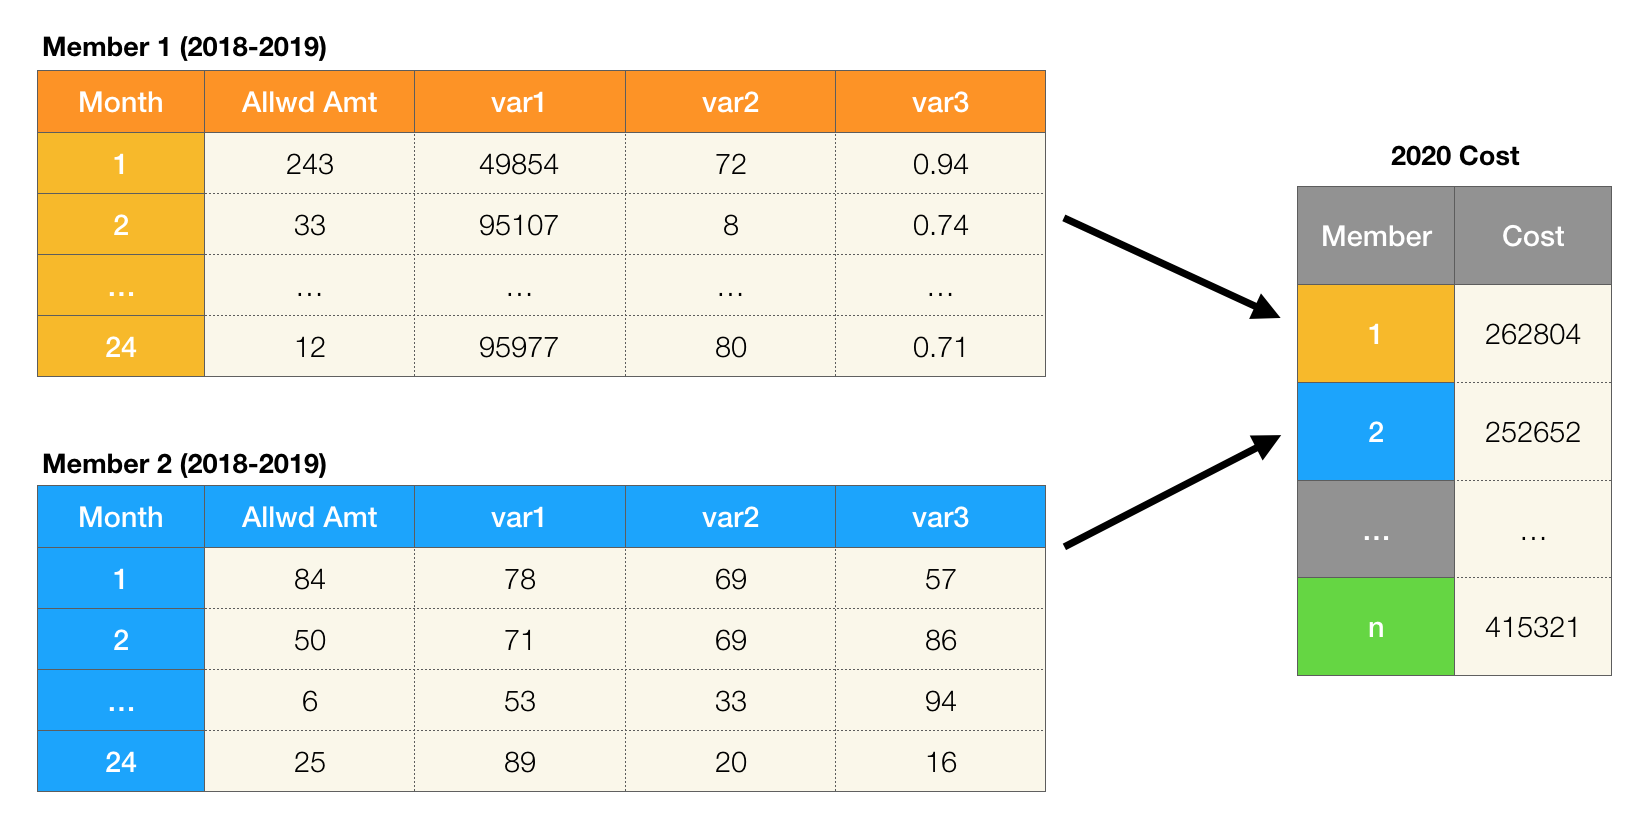